### Nonlinear Function

Given a $\phi$ and $\phi^{-1}$ (trained in Quantum autoencoder) such that $\phi^{-1}\circ\phi|\alpha\rangle = |\alpha\rangle$ and $dim(\phi|\alpha\rangle) < dim(|\alpha\rangle)$, we want to find a function $f$ such that $\phi^{-1}\circ f\circ\phi|\alpha_k\rangle = |\alpha_{k+1}\rangle$.

In [1]:
import matplotlib.pyplot as plt         
import tensorflow as tf
import numpy as np
import os
import pandas as pd

import sys

sys.path.append('..')
from utils import *
sys.path.remove('..')

from nonlinear_utils import *


#Some GPU configuration
#Always uses the 1st GPU avalible (if avalible) unless 1st line is uncommented, in which case no GPU is used

#tf.config.set_visible_devices([], 'GPU') #uncomment to set tensorflow to use CPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
elif len(physical_devices) == 0:
    print("Warning: No GPU detected.  Running tensorflow on CPU")

In [2]:
Phi = tf.keras.models.load_model('../Autoencoder/Autoencoder_Trials/models/trial25e1000Phi.h5', compile=False)
Phi_inv = tf.keras.models.load_model('../Autoencoder/Autoencoder_Trials/models/trial25e1000Phi_inv.h5', compile=False)

In [11]:
#import tensorflow_datasets as tfds
test, val = interleave_test('../../QuantumTeam/data/50000inits_dt0p1_compressed/', 20000, 18000)
test = test.batch(100000).prefetch(tf.data.experimental.AUTOTUNE)
val = val.batch(100000).prefetch(2)
#bench = tfds.benchmark(test, num_iter=10, batch_size=100000)
#test = read_single_file('../../QuantumTeam/data/master_test.csv', 10000, 500)
#test = test.batch(100000)

In [60]:
def L2_loss(y_true, y_pred):
    end = Phi_inv(y_pred)
    print(y_true-end)
    return tf.norm(y_true-end, ord=2, axis=-1)

In [23]:
inputs = tf.keras.Input(shape=3)


nonlinear_layer_1 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_1')(inputs)
nonlinear_layer_2 = tf.keras.layers.Dense(256, activation='selu', name='nonlinear_layer_2')(nonlinear_layer_1)
nonlinear_layer_3 = tf.keras.layers.Dense(512, activation='selu', name='nonlinear_layer_3')(nonlinear_layer_2)
nonlinear_layer_4 = tf.keras.layers.Dense(512, activation='selu', name='nonlinear_layer_4')(nonlinear_layer_3)
nonlinear_layer_5 = tf.keras.layers.Dense(256, activation='selu', name='nonlinear_layer_5')(nonlinear_layer_4)
nonlinear_layer_6 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_6')(nonlinear_layer_5)
evolved = tf.keras.layers.Dense(3, activation='selu', name='evolved_state_layer')(nonlinear_layer_6)

NonlinearEvolution = tf.keras.Model(inputs=inputs, outputs=evolved)

In [61]:
NonlinearEvolution.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss=L2_loss, metrics=['mse', 'mae'])

In [ ]:
%%time
history = NonlinearEvolution.fit(train, epochs=5)

In [11]:
write_history(history, NonlinearEvolution,loss='L2_loss',batch_size='100000', other_info={'dataset':'50000inits_dt0p1 (First 5000 evolutions)','validation':'500inits'})

'./datafiles/trial40.data'

In [10]:
append_history(history, params={'Learning Rate':.0001})

In [182]:
NonlinearEvolution.save('./models/trial39e500.h5')

In [4]:
NonlinearEvolution = tf.keras.models.load_model('./dataspace_tests/tests/dt0p1_tests/0t50/models/15000inits_dt0p1.h5', compile=False)

In [12]:
note_history(35,'./datafiles/', 'Only the first 2000 inits were used')

In [ ]:
loss_plot('./dataspace_tests/dt0p1_tests/0t10/datafiles/0t10_dt0p1_15000inits.data', savefig=False, skip_epochs=10, mark_lowest=False)

## Visualizations

In [13]:
NonlinearEvolution, data, learned = predict_and_load('../../QuantumTeam/data/long_evolutions/big_evolve0p1.csv', 10, 0.025, 15000)

In [73]:
predict_evolution('../../QuantumTeam/data/long_evolutions/big_evolve0p1.csv', save_prediction=True, saved_name='./predicted_evolutions/0t50_dt0p1_15000inits_first.csv', save_compressed=True, saved_compressed_name='./predicted_evolutions/0t50_dt0p1_15000inits_first_compressed.csv', timesteps=5000)

array([[ 1.0007371 ,  0.00282227,  0.00116324,  0.00240903],
       [ 0.99061644, -0.05735017, -0.08402971, -0.09121983],
       [ 0.96148956, -0.10969258, -0.1691527 , -0.18019778],
       ...,
       [ 0.15559158,  0.8336573 ,  0.12976351,  0.5131924 ],
       [ 0.25811416,  0.84306014,  0.20065661,  0.42765516],
       [ 0.36050147,  0.8327766 ,  0.26346546,  0.33116964]],
      dtype=float32)

In [83]:
#Read in evolution data for plotting 
data = np.genfromtxt("../../QuantumTeam/data/long_evolutions/big_evolve0p1.csv", delimiter=",", skip_header=1)
learned = np.genfromtxt('./predicted_evolutions/0t10_dt0p1_15000inits_long_evolve.csv', delimiter=",", skip_header=1)

In [21]:
#Check that magnitude is approximately 1
timerange=1000
r1l = np.sqrt(learned[:timerange,1]**2 + learned[:timerange,2]**2)
r2l = np.sqrt(learned[:timerange,3]**2 + learned[:timerange,4]**2)
thetal = np.arctan2(learned[:timerange,4],learned[:timerange,3]) - np.arctan2(learned[:timerange,2],learned[:timerange,1])

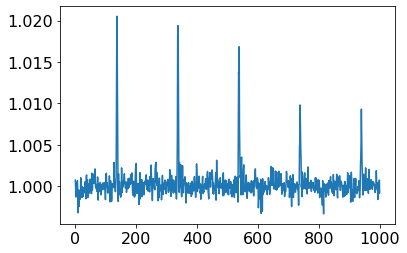

In [22]:
plt.plot(learned[:1000,0], np.sqrt(r1l[:1000]**2+r2l[:1000]**2))

In [ ]:
plot_dynamics(data, learned, phispace=False, truespace=True, expectation=False, savefig=False,figname='./figures/0t10_dt0p1_15000inits_long_train_phispace_1000t2000.png', timerange=2000, timestart=1000)

In [ ]:
create_animation_frames(data, learned, timesteps=1000)

0.25909567
-1.1006664


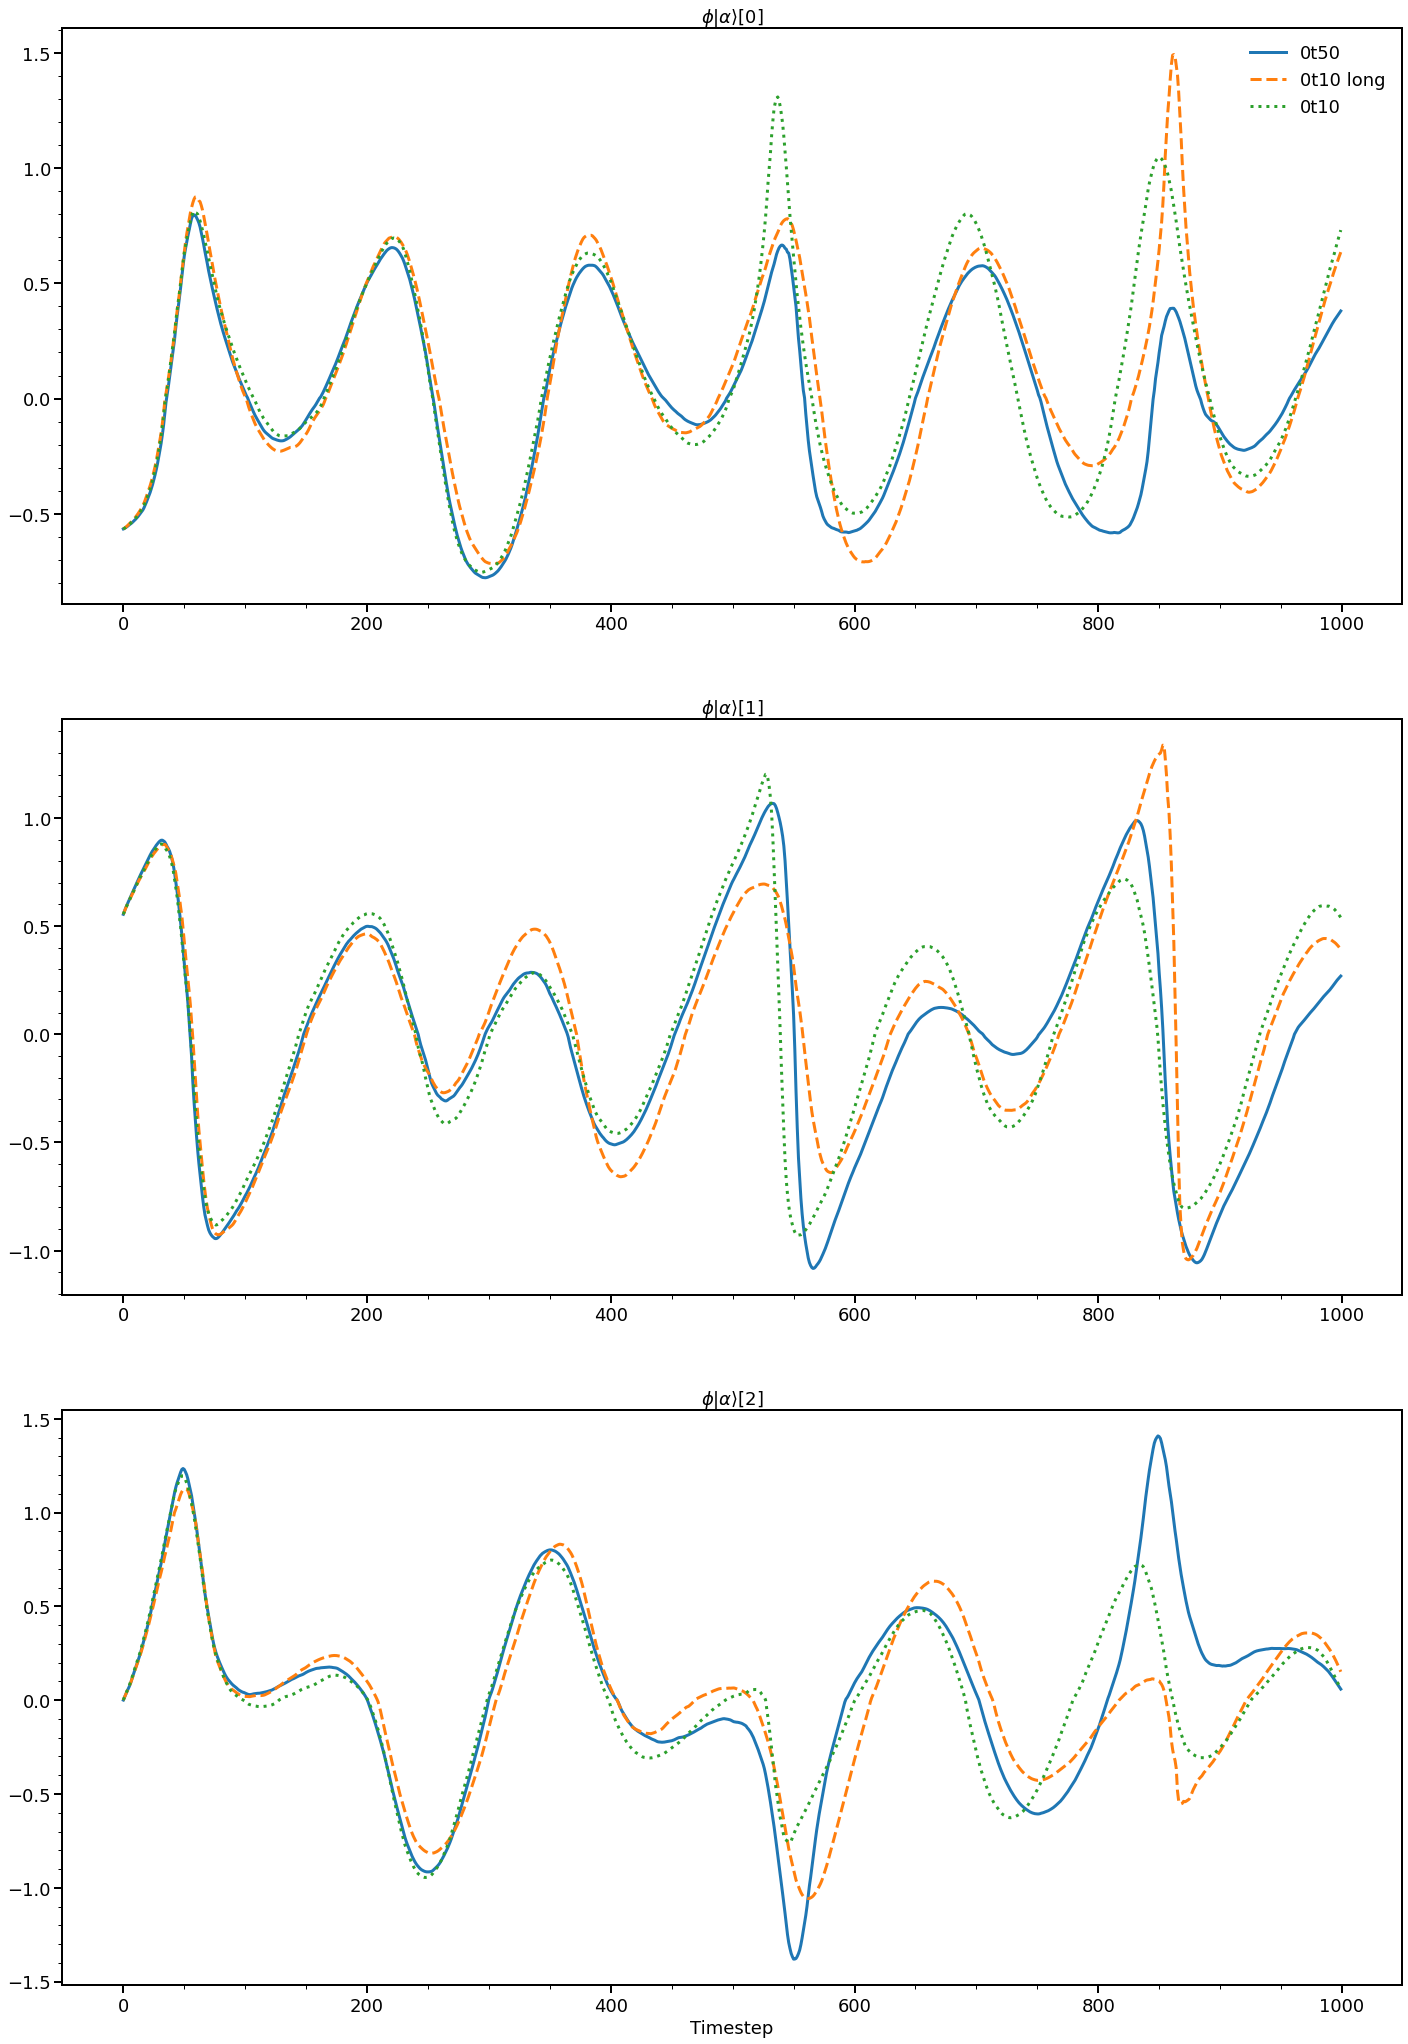

In [8]:
#Read in evolution data for plotting 
#data = np.genfromtxt("../../QuantumTeam/data/long_evolutions/big_evolve0p1.csv", delimiter=",", skip_header=1)
t10_long = np.genfromtxt('./predicted_evolutions/0t10_dt0p025_15000inits_2x.csv', delimiter=",", skip_header=1)
t20 = np.genfromtxt('./predicted_evolutions/0t20_dt0p025_15000inits.csv', delimiter=',', skip_header=1)
t10 = np.genfromtxt('./predicted_evolutions/0t10_dt0p025_15000inits.csv', delimiter=',', skip_header=1)


t10_long_compressed = Phi(t10_long[:,1:]).numpy()
t20_compressed = Phi(t20[:,1:]).numpy()
t10_compressed = Phi(t10[:,1:]).numpy()

FONTSIZE=18
plt.rc('font', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE,labelsize=FONTSIZE, linewidth=2)
plt.rc('legend', fontsize=FONTSIZE)
plt.rc('xtick', labelsize=FONTSIZE)
plt.rc('ytick', labelsize=FONTSIZE)
plt.rc('figure', titlesize=FONTSIZE)
plt.rc('lines', linewidth=3)

timestart=0
timerange = 1000

fig,ax = plt.subplots(3,1, figsize=(24,36))

#ax[0].plot(t20[timestart:timerange,0], t20_compressed[timestart:timerange,0] - t10_long_compressed[timestart:timerange,0], label='0t50')
ax[0].plot(t20[timestart:timerange,0], t20_compressed[timestart:timerange,0], label='0t50')
ax[0].plot(t10_long[timestart:timerange,0], t10_long_compressed[timestart:timerange,0], ls='--', label='0t10 long')
ax[0].plot(t10[timestart:timerange,0], t10_compressed[timestart:timerange,0], ls=':', label='0t10')

ax[1].plot(t20[timestart:timerange,0], t20_compressed[timestart:timerange,1])
ax[1].plot(t10_long[timestart:timerange,0], t10_long_compressed[timestart:timerange,1], ls='--')
ax[1].plot(t10[timestart:timerange,0], t10_compressed[timestart:timerange,1], ls=':')

ax[2].plot(t20[timestart:timerange,0], t20_compressed[timestart:timerange,2])
ax[2].plot(t10_long[timestart:timerange,0], t10_long_compressed[timestart:timerange,2], ls='--')
ax[2].plot(t10[timestart:timerange,0], t10_compressed[timestart:timerange,2], ls=':')

#ax[3].plot(t50[timestart:timerange,0], t50[timestart:timerange,4])
#ax[3].plot(t10_long[timestart:timerange,0], t10_long[timestart:timerange,4], ls='--')
#ax[3].plot(t10[timestart:timerange,0], t10[timestart:timerange,4], ls=':')


ax[0].legend(frameon=False)
ax[2].set_xlabel('Timestep')



ax[0].set_title(r'$\phi|\alpha\rangle[0]$')
ax[1].set_title(r'$\phi|\alpha\rangle[1]$')
ax[2].set_title(r'$\phi|\alpha\rangle[2]$')
#ax[3].set_title(r'$\delta$')

for i in range(3):
    ax[i].tick_params(length=8,width=2, which='major')
    ax[i].tick_params(length=4,width=1, which='minor')

    ax[i].minorticks_on()
    
fig.savefig('./figures/0t50_0t10_long_training_comparison_phispace_fixed.png',dpi=200)

print(max(t20_compressed[timestart:timerange,0] - t10_long_compressed[timestart:timerange,0]))
print(min(t20_compressed[timestart:timerange,0] - t10_long_compressed[timestart:timerange,0]))

## Evolution Quality Metric

Several metrics for measuring the quality of an evolution beyond just eyeballing it.

- $max\|\phi^{-1}\circ F\circ\phi(\alpha(a+b)) - \left(\alpha\phi^{-1}\circ F\circ\phi(a)+\alpha\phi^{-1}\circ F\circ\phi(b)\right)\|_2$
    - This metric is better the smaller it is.  Ideally, we should be able to recover the linearity of the Schroedinger equation.
    - a and b are selected such that a+b is also in the (compressed) training set.  This is to ensure that any difference between the two terms is a result of lingering nonlinearity, rather than poor predictions.
    - Maybe do average instead of max?
    - (Actually defined in the 'Checking Nonlinearity' section)
    
- Validation loss normalized with timestep
    - Essentially interprets as if our loss were to stay constant, how far off would we be from the true evolution after 1 unit of time?

Some metrics for the dataset itself.  Not entirley convinced the spatial density test is working yet, but the temporal one should be.

The spatial density test essentially slices the Bloch sphere through a plane which the axis of procession lies in.  This creates a circle, though we only worry about the upper arc.  We then check the spacing of the evolutions on that arc.  We only need to load in a single point from each evolution, the function 'completes' the evolution by projecting the points onto the procession axis and then re-projecting them back onto the arc, essentially just lining all the points up.

The temporal density test takes some evolution and moves its frame to be in the plane which the evolution lies in.  It then defines the initial condition as the 'zero angle' and measures the angle all the other evolution points relative to the zero angle.  This gives an idea of the spacing of the points in the evolution (though two points which are next to each other on the Bloch sphere may not be next to each other in the evolution; our sampling rate will cause each evolution to be offset slightly from the previous).

In [9]:
def dataspace_plot(datadir, yaxis, dt_major = False):
    fig, ax = plt.subplots(2,2, figsize=(16,14), sharex=True)
    
    FONTSIZE=20
    plt.rc('font', size=FONTSIZE)
    plt.rc('axes', titlesize=FONTSIZE,labelsize=FONTSIZE,linewidth=3)
    plt.rc('legend', fontsize=FONTSIZE)
    plt.rc('xtick', labelsize=FONTSIZE)
    plt.rc('ytick', labelsize=FONTSIZE)
    plt.rc('figure', titlesize=FONTSIZE)
    
    TIMERANGE = (10,15,20,50)
    GRID = [(0,0),(0,1),(1,0),(1,1)]
    DATASETSIZES = (2000, 3000,4000,5000,7500,10000,12500,15000,17500, 20000, 25000,30000,35000,40000,45000,50000)
    TIMESTEPS = (0.1,0.075,0.05,0.025)

    linestyles = ['-', '--', '-.', ':']
    
    

In [28]:
normalized_val_loss('./dataspace_tests/datafiles/0t15_dt0p075_10000inits.data', .075)

0.05100538022816181

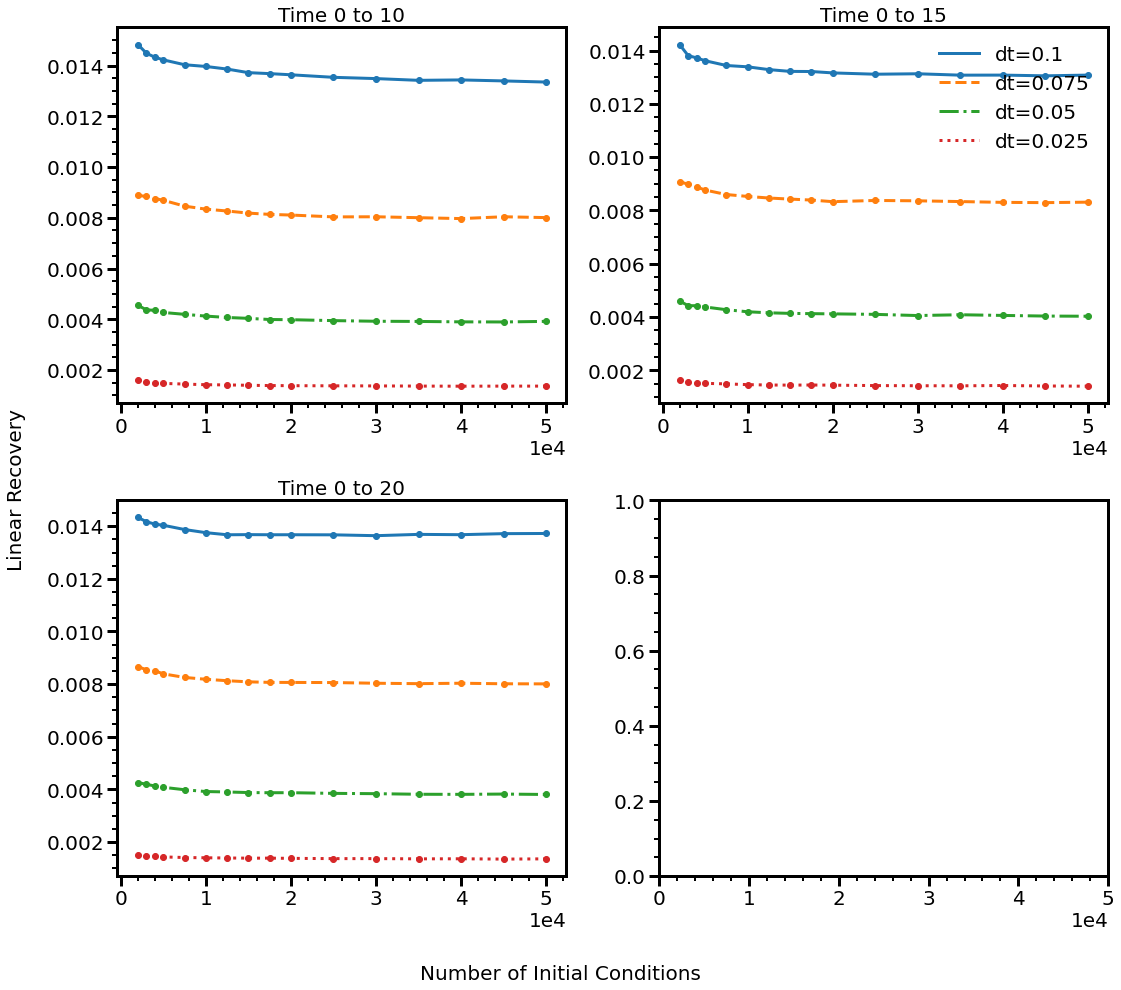

In [26]:
fig, ax = plt.subplots(2,2, figsize = (16,14), sharex=True)

FONTSIZE=20
plt.rc('font', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE,labelsize=FONTSIZE,linewidth=3)
plt.rc('legend', fontsize=FONTSIZE)
plt.rc('xtick', labelsize=FONTSIZE)
plt.rc('ytick', labelsize=FONTSIZE)
plt.rc('figure', titlesize=FONTSIZE)

#DONT FORGET TO ADD IN 0t50 ONCE IT IS DONE PRE-PROCESSING
TIMERANGE = (10,15,20)
GRID = [(0,0),(0,1),(1,0),(1,1)]

DATASETSIZES = (2000, 3000,4000,5000,7500,10000,12500,15000,17500, 20000, 25000,30000,35000,40000,45000,50000)

TIMESTEPS = (0.1,0.075,0.05,0.025)

linestyles = ['-', '--', '-.', ':']

for col, time in enumerate(TIMERANGE):
    for style, timestep in enumerate(TIMESTEPS): 
        #losses = np.genfromtxt('./dataspace_tests/misc_results/nonlinearities/0t{}_dt{}_nonlinearities.csv'.format(time, str(timestep).replace('.','p')), delimiter=',', skip_header=1)[:,1:]
        losses = np.genfromtxt('./dataspace_tests/misc_results/linear_recoveries/0t{}_dt{}_50000inits_linear_recovery.csv'.format(time, str(timestep).replace('.','p')), delimiter=',', skip_header=1)[:,1:]
        #losses = losses / timestep
        ax[GRID[col]].plot(DATASETSIZES,losses, label='dt={}'.format(timestep), lw=3, ls=linestyles[style%4])
        ax[GRID[col]].scatter(DATASETSIZES,losses)
    


    


ax[0,1].legend(frameon=False)


#ax[1,0].set_xlabel('Number of initial conditions')
#ax[1,1].set_xlabel('Number of initial conditions')

#ax[1,0].set_ylabel('Normalized validation loss')
#ax.set_title('dt=0.025')

for i,ax in enumerate(ax.reshape(-1)):
    ax.tick_params(length=10,width=3, which='major')
    ax.tick_params(length=5,width=2, which='minor')

    ax.minorticks_on()

    if i!=3:
        ax.set_title('Time 0 to {}'.format(TIMERANGE[i]))
        
    ax.ticklabel_format(axis='x',scilimits=(0,0))
    ax.set_xticks([0,10000,20000,30000,40000,50000])

fig.supylabel('Linear Recovery')
fig.supxlabel('Number of Initial Conditions')

fig.tight_layout()

fig.savefig('/storage/Documents/programming/machine_learning/BYU/git/writeup/figures/nonnorm_linear_recovery.png',dpi=150)

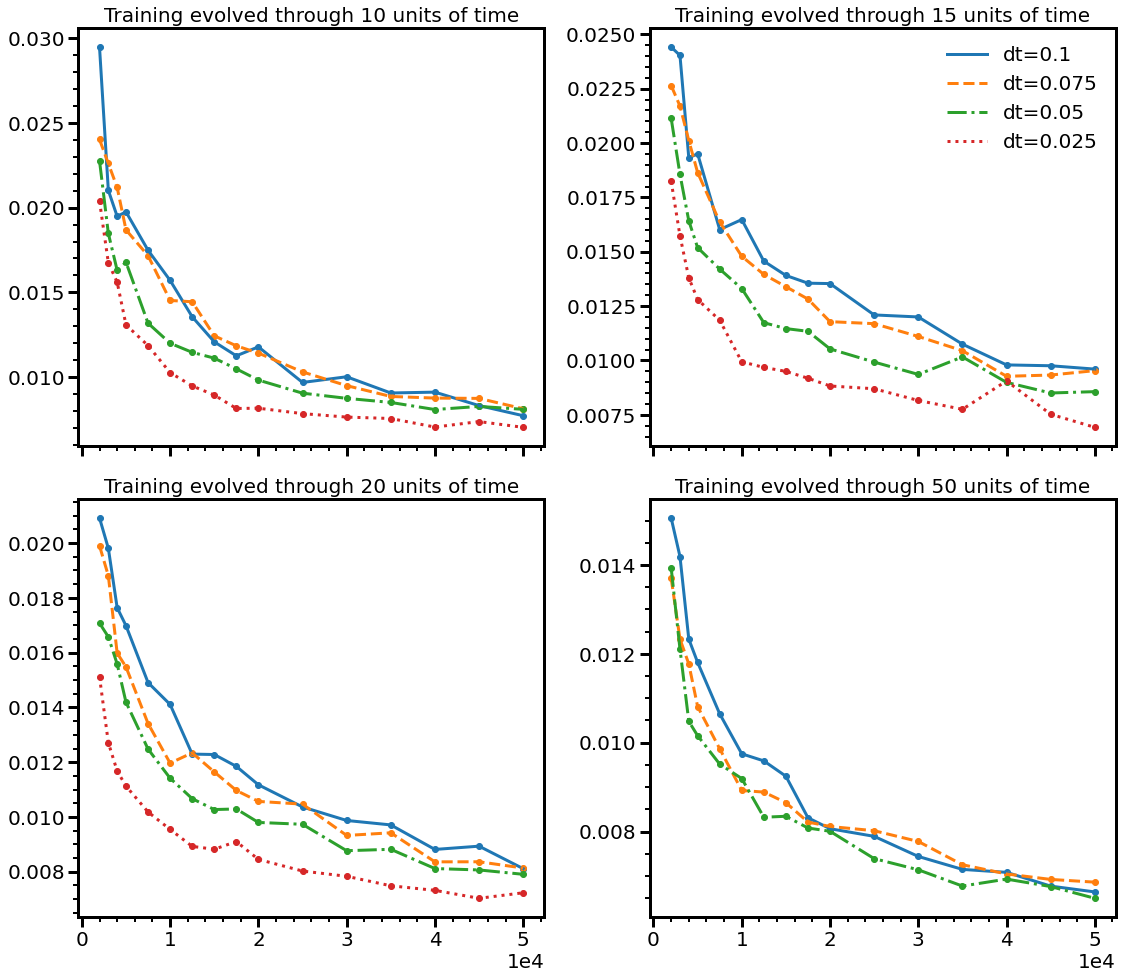

In [5]:
fig, ax = plt.subplots(2,2,figsize = (16,14), sharex=True)


FONTSIZE=20
plt.rc('font', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE,labelsize=FONTSIZE,linewidth=3)
plt.rc('legend', fontsize=FONTSIZE)
plt.rc('xtick', labelsize=FONTSIZE)
plt.rc('ytick', labelsize=FONTSIZE)
plt.rc('figure', titlesize=FONTSIZE)



DATASETSIZES = (2000, 3000,4000,5000,7500,10000,12500,15000,17500, 20000, 25000,30000,35000,40000,45000,50000)
TIMERANGES = (10,15,20,50)
TIMESTEPS = (0.1,0.075,0.05,0.025)

grid = [(0,0),(0,1),(1,0),(1,1)]
linestyles = ['-', '--', '-.', ':']


for row, time in enumerate(TIMERANGES):
    for style,timestep in enumerate(TIMESTEPS):
    
        if time==50 and timestep == 0.025:
            continue
        STRTIMESTEP = str(timestep).replace('.','p')
        losses = []
        for size in DATASETSIZES:
            losses.append((normalized_val_loss('./dataspace_tests/datafiles/0t{}_dt{}_{}inits.data'.format(time, STRTIMESTEP,size),timestep)*timestep)/(timestep**0.5))
        ax[grid[row]].plot(DATASETSIZES,losses, label='dt={}'.format(timestep), lw=3, ls=linestyles[style%4])
        ax[grid[row]].scatter(DATASETSIZES,losses)





ax[0,1].legend(frameon=False)

#ax[1,0].set_xlabel('Number of initial conditions')
#ax[1,1].set_xlabel('Number of initial conditions')

#ax[1,0].set_ylabel('Normalized validation loss')
#ax.set_title('dt=0.025')

for i,ax in enumerate(ax.reshape(-1)):
    ax.tick_params(length=10,width=3, which='major')
    ax.tick_params(length=5,width=2, which='minor')

    ax.minorticks_on()

    #if i!=3:
    ax.set_title('Training evolved through {} units of time'.format(TIMERANGES[i]))
        
    ax.ticklabel_format(axis='x',scilimits=(0,0))
    ax.set_xticks([0,10000,20000,30000,40000,50000])

#fig.supylabel('Validation Loss')
#fig.supxlabel('Number of Initial Conditions')

fig.tight_layout()



#Have a shared y-axis for non normalized?
##All seem to be in the same range, just waiting on 0t50

#fig.savefig('/storage/Documents/programming/machine_learning/BYU/git/writeup/figures/nonnorm_val_loss.png',dpi=150)

In [5]:
#Create a 'graph' of memory usage for a given configuration
##We get about 5000000 points per 8GB of memory.  Not perfectly accurate, (tends to report high)
##but seems to be a pretty good approximation

import itertools

timesteps = [0.1,0.075,0.05,0.025,0.01,0.0075,0.005,0.0025,0.001]
initial_conditions = [2000,3000,4000,5000,7500,10000,12500,15000,17500,20000,25000,30000,35000,40000,45000,50000]
total_times = [5,10,15,20,25,50]

#timestep x initial conditions x total time
points = np.empty([len(total_times),len(initial_conditions),len(timesteps)])

for i,j,k in itertools.product(range(len(total_times)), range(len(initial_conditions)), range(len(timesteps))):
    points[i,j,k] = (total_times[i]/timesteps[k]) * initial_conditions[j]

In [125]:
GB = lambda x: (5000000/8)*x #Convert gigs to points (8GB is ~5000000 points)
points <= GB(64)

array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True, 

## Checking Nonlinearity

We want to check that $F^t[\phi(v)+\phi(w)]\neq F^t[\phi(v)] + F^t[\phi(w)]$.  To this end, we find triples $v,w,$ and $v+w$ such that $\phi(v),\phi(w),$ and $\phi(v)+\phi(w)$ are all in our training set to ensure that any inequality is due to nonlinearity rather than innacurate predictions.



In [30]:
def compress_evolution(evolution_path, save_path):
    evolution = np.genfromtxt(evolution_path, delimiter=',', skip_header=1)[:,1:]
    compressed_evolution = Phi(evolution).numpy()
    pd.DataFrame(compressed_evolution).to_csv(save_path)
    


In [240]:
datapath = '../../QuantumTeam/data/'
for i in range(5000):
    compress_evolution(datapath+'5000inits_dt0p1/evolution{}.csv'.format(i), datapath+'5000inits_dt0p1_compressed/evolution{}.csv'.format(i))

In [53]:
#ayys, bs, apbs = read_sum_pair_triples('./dataspace_tests/sum_pair_triples/0t10_dt0p1_50000inits_sum_pair_triples_bloch.csv', 1, compressed=False)

#alpha = 1/np.linalg.norm(ayys+bs, axis=-1)
#alpha = alpha.reshape(len(alpha), 1)

#apbs_compressed = Phi(apbs).numpy()
#Fapb = NonlinearEvolution(apbs_compressed).numpy()
#apb_evolved = Phi_inv(Fapb).numpy()

#ayys_compressed = Phi(ayys).numpy()
#Fa = NonlinearEvolution(ayys_compressed).numpy()
#a_evolved = Phi_inv(Fa).numpy()
    
#bs_compressed = Phi(bs).numpy()
#Fb = NonlinearEvolution(bs_compressed).numpy()
#b_evolved = Phi_inv(Fb).numpy()

linear_recovery_metric('./dataspace_tests/sum_pair_triples/0t10_dt0p1_50000inits_sum_pair_triples_bloch.csv', 1, timerange=10, timestep=0.1, num_inits=15000, average=True)

0.014904627136103006

Wall time: 1h 53min 2s


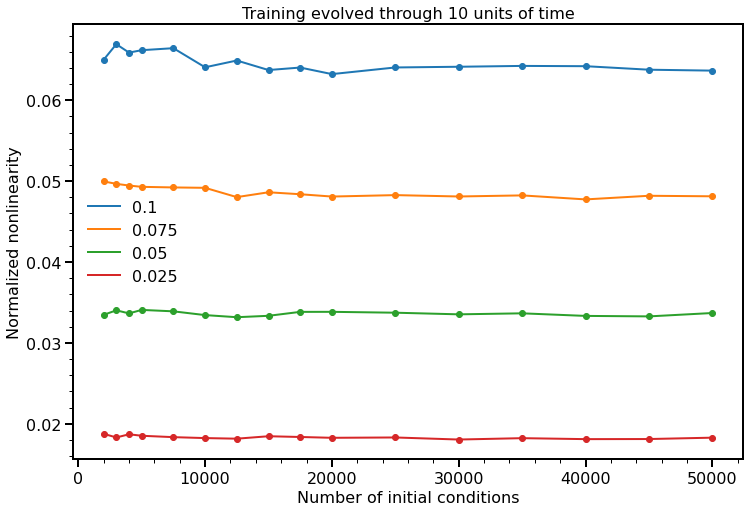

In [13]:
%%time

fig, ax = plt.subplots(figsize = (12,8))

FONTSIZE=16
plt.rc('font', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE,labelsize=FONTSIZE)
plt.rc('legend', fontsize=FONTSIZE)
plt.rc('xtick', labelsize=FONTSIZE)
plt.rc('ytick', labelsize=FONTSIZE)
plt.rc('figure', titlesize=FONTSIZE)

TIMERANGE=15

DATASIZES = [2000,3000,4000,5000,7500,10000,12500,15000,17500,20000,25000,30000,35000,40000,45000,50000]

for i in [0.1,0.075,0.05,0.025]:
    stri = str(i).replace('.','p')
    nonlinearities = []
    vs, ws, vpws = read_sum_pair_triples('./dataspace_tests/sum_pair_triples/0t{}_dt{}_50000inits_sum_pair_triples.csv'.format(TIMERANGE,stri), 500)
    for j in DATASIZES:
        NonlinearEvolution = tf.keras.models.load_model('./dataspace_tests/models/0t{}_dt{}_{}inits.h5'.format(TIMERANGE,stri,j), compile=False)
        avg = 0

        for k in range(len(vs)):
            vpw = np.array([vpws[k],])
            v = np.array([vs[k],])
            w = np.array([ws[k],])
            lhs = NonlinearEvolution(vpw).numpy()[0]
            rhs = NonlinearEvolution(v).numpy()[0] + NonlinearEvolution(w).numpy()[0]
            avg += np.linalg.norm(lhs-rhs)
        nonlinearities.append((avg/len(vs)))
    ax.plot(DATASIZES,nonlinearities,lw=2,label=i)
    ax.scatter(DATASIZES,nonlinearities)
    #pd.DataFrame(nonlinearities).to_csv('./dataspace_tests/misc_results/nonlinearities/0t{}_dt{}_nonlinearities.csv'.format(TIMERANGE, stri))

        
        
ax.legend(frameon=False)
ax.set_xlabel('Number of initial conditions')
ax.set_ylabel('Normalized nonlinearity')
ax.set_title('Training evolved through 10 units of time')

ax.tick_params(length=8,width=2, which='major')
ax.tick_params(length=4,width=1, which='minor')

for k in ['left','right','top','bottom']:
    ax.spines[k].set_linewidth(2)
    
ax.minorticks_on()

#fig.savefig('./figures/0t15_nonlinearities_normalized.png', dpi=150)

### Old/unused functions

May still be useful as refrence/figure out what we were doing before, but not immidietley useful to the program and just cluttering up the notebook otherwise

In [186]:
##NOTE: The 2D compression tools do not work, only the 3D ones
def ideal_phi_2D(states):
    theta = np.math.atan2(states[1],states[0]) - np.math.atan2(states[3],states[2])
    r = np.sqrt(states[0]*states[0]+states[1]*states[1])
    return np.array([r, theta])

def ideal_phi_2D_inv(compressed):
    r, theta = compressed[0], compressed[1]
    
    alpha = r*np.cos(theta)
    beta = r*np.sin(theta)
    gamma = np.sqrt(1-r*r)
    delta = 0.
    return np.array([alpha, beta, gamma, delta])





#These compressions fail because sign information on the fourth dimension is lost w/ the square root

def ideal_phi_3D(states):
    return np.array([states[0], states[1], states[2]])

def ideal_phi_3D_inv(compressed):
    diff = 1-compressed[0]*compressed[0]-compressed[1]*compressed[1]-compressed[2]*compressed[2]
    if diff >=0.:
        fourth_component = np.sqrt(diff)
    else:
        fourth_component = 0.
    return np.array([compressed[0], compressed[1], compressed[2], fourth_component])



#These compressions work as compressions, but the nonlinear model has a really hard time
##learning off them for some reason
def ideal_phi_3D(state):
    assert (len(state)==4),'State must be 4 dimensions to compress to 3'
    r1 = np.sqrt(state[0]*state[0] + state[1]*state[1])
    r2 = np.sqrt(state[2]*state[2]+state[3]*state[3])
    phi1 = np.math.atan2(state[1],state[0])
    phi2 = np.math.atan2(state[3],state[2])
    return np.array([r1, r2, phi2-phi1])

def ideal_phi_3D_inv(state):
    assert (len(state) == 3),'Compressed state must be 3 dimensions to be decompressed'
    alpha = state[0]
    beta = 0.
    gamma = state[1]*np.cos(state[2])
    delta = state[1]*np.sin(state[2])
    return np.array([alpha, beta, gamma, delta])



def get_relative_phase(vector):
    '''Returns the relative phase between
    the two complex components of a two
    complex dimensional vector
    Assumes the vector is passed in as a 
    four dimensional real row vector of form
    [real1, imag1, real2, imag2]
    '''
    

    #Tensorflow likes to return a list of a single
    #element sometimes, which breaks this function
    #This does not happen during training, only when
    #manually run on a single vector
    if vector.shape == (4,):
        return tf.atan2(vector[1], vector[0])%(2*np.pi) - tf.atan2(vector[3], vector[2])%(2*np.pi)

    return tf.atan2(vector[:,1],vector[:,0])%(2*np.pi) - tf.atan2(vector[:,3],vector[:,2])%(2*np.pi)


#We never train on just a single evolution anymore
def get_evolution_data(evolution_data, ideal_pre_compress_3D=False, pre_compress_phi=False):
    '''Read in evolution data from a csv file
    
    PARAMS:
    -------
    str evolution_data: Path to evolution datafile we wish to read
    bool ideal_pre_comrpess_3D: If true, uses ideal compression functions to 
                                  compress evolution data into specified dimension
    bool pre_compress_phi: If true, use the Phi neural net model to compress
                           evolution data
    
    RETURNS:
    --------
    tf.data.Dataset: Shuffled dataset of evolution values
    '''

    evolution_file = evolution_data
    
    with open(evolution_file, 'r') as f:
        data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
        
        if ideal_pre_compress_3D:
            data = np.array([ideal_phi_3D(x) for x in data])
        elif pre_compress_phi:
            data = Phi(data)
 
    
        pre_evolution = np.empty([len(data)-1, len(data[0])])
        post_evolution = np.empty([len(data)-1, len(data[0])])
   
        pre_evolution[0] = data[0]
        
        for i,k in enumerate(data[1:-1]):
            pre_evolution[i+1] = k
            post_evolution[i] = k
            
        post_evolution[-1] = data[-1]
        

        ds = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
            
        
        return ds.shuffle(100000, reshuffle_each_iteration=True)
    
    
#Much too slow to be useable, likley due to get_evolution_data's reliance on CsvDataset
##Can't read in data fast enough to keep up with training, can be as slow as 4s/step
###for datasets with longer evolutions
##Uses get_evolution_data below
def interleave_test(datadir, max_evolution, training_evolutions, pre_compress_phi=True):
    training_filenames = [datadir+'evolution{}.csv'.format(x) for x in range(training_evolutions)]
    training_files = tf.data.Dataset.from_tensor_slices(training_filenames)
    validation_filenames = [datadir+'evolution{}'.format(x) for x in range(training_evolutions, max_evolution)]
    validation_files = tf.data.Dataset.from_tensor_slices(validation_filenames)
    training_files = training_files.interleave(lambda x: get_evolution_data(x), num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000000, reshuffle_each_iteration=True)
    validation_files = validation_files.interleave(lambda x:get_evolution_data(x), num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000000, reshuffle_each_iteration=True)
    return training_files,validation_files 
    
    
#We never train on just a single evolution anymore
def get_evolution_data(evolution_data):
    '''Read in evolution data from a csv file
    
    PARAMS:
    -------
    str evolution_data: Path to evolution datafile we wish to read
    bool ideal_pre_comrpess_3D: If true, uses ideal compression functions to 
                                  compress evolution data into specified dimension
    bool pre_compress_phi: If true, use the Phi neural net model to compress
                           evolution data
    
    RETURNS:
    --------
    tf.data.Dataset: Shuffled dataset of evolution values
    '''

    evolution_file = evolution_data

    data = tf.data.experimental.CsvDataset(evolution_file, [tf.float32, tf.float32, tf.float32], select_cols=[1,2,3], header=True)
    
    data = data.map(lambda a,b,c: tf.stack([a,b,c]))


        
    pre_evolution = data.take(data.cardinality()-1)
    post_evolution = data.skip(1).take(data.cardinality()-1)
    
    ds = tf.data.Dataset.zip((pre_evolution, post_evolution))
            
    return ds
    #return ds.shuffle(1000000, reshuffle_each_iteration=True)
    
    

    

#Some old keras Sequence generators
#Don't even know if these are still supported or not tbh
class evolution_training_data_generator(tf.keras.utils.Sequence):
    '''Sequence to load in dataset incrementally, rather than all at once.  evolution_training_data_generator and 
    evolution_validation_data_generator should take the same arguments
    
    PARAMS:
    -------
    
    str datadir - path containing the evolution{}.csv files
    
    int max_evolution - the largest evolution file to include in the dataset
                        NOTE: We read evolution0.csv through evolution{max_evolution-1}.csv, not
                              some random sample of evolution files (though the data from the ones
                              that we do select will be shuffled if shuffle is set True)
                              
    int training_evolutions - The number of evolution files which will be training data
                              NOTE: The first training_evolutions files will be the training data,
                                    not some shuffled sample
                                    
    int batch_size - The number of evolution files to include in a sample
                     This is not the number of points we are training on, but the number of 
                     evolution files.  500 timesteps per evolution and a batch size of 200 -> 100000
                     points per batch.  Batch size of 200 seems to be just about the max for 2GB of VRAM.
                     
    bool shuffle - Whether or not to shuffle the order in which we read our evolution files in
    bool pre_compress_phi - Whether or not to use Phi to compress our data right away.  Should pretty much always be True
    '''
    
    def __init__(self, datadir, max_evolution, training_evolutions, batch_size=200, shuffle=True, pre_compress_phi=True):
        self.datadir = datadir
        self.max_evolution = training_evolutions
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.pre_compress_phi=pre_compress_phi
        
        #Initilize the sampling indices
        self.on_epoch_end()
        
    #The indices essentially correspond to the 
    ##evolution files
    def on_epoch_end(self):
        self.indexes = np.arange(self.max_evolution)
        if (self.shuffle):
            np.random.shuffle(self.indexes)
            
    #This determines the number of batches per epoch
    def __len__(self):
        return int(np.floor(self.max_evolution / self.batch_size))
            
        
    #Index corresponds to batch number here, has no
    ##direct relation to self.indexes
    def __getitem__(self, index):
        pre_evolution = []
        post_evolution = []
        
        #Grab the batch size evolutions that we want
        indices = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
                
        
        #From here on, basically the same as get_multiple_evolutions
        for i in indices:
            with open(self.datadir+'evolution{}.csv'.format(i),'r') as f:
                data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
                
                if self.pre_compress_phi:
                    data = Phi(data)
                 
                #This was handled by the tf.dataset.shuffle in get_multiple_evolutions
                data = tf.random.shuffle(data)
                    
                pre_evolution.append(data[0])
                
                for k in data[1:-1]:
                    pre_evolution.append(k)
                    post_evolution.append(k)
                
                post_evolution.append(data[-1])
                    
        pre_evolution = tf.convert_to_tensor(pre_evolution)
        post_evolution = tf.convert_to_tensor(post_evolution)

        return pre_evolution, post_evolution
    
    
class evolution_validation_data_generator(tf.keras.utils.Sequence):
    
    def __init__(self, datadir, max_evolution, training_evolutions, batch_size=200, shuffle=True, pre_compress_phi=True):
        self.datadir = datadir
        self.max_evolution = max_evolution
        self.evolution_offset = training_evolutions
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.pre_compress_phi=pre_compress_phi
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.indexes = np.arange(self.evolution_offset,self.max_evolution)
        if (self.shuffle):
            np.random.shuffle(self.indexes)
            
    #Our data is batched in terms of initial conditions, so
    ##our length is based on the number of initial conditions used,
    ##not the raw number of points
    def __len__(self):
        return int(np.floor( (self.max_evolution-self.evolution_offset) / self.batch_size))
            
    def __getitem__(self, index):
        pre_evolution = []
        post_evolution = []
        
        #Grab the batch size evolutions that we want
        indices = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
                
        
        #From here on, basically the same as get_multiple_evolutions
        for i in indices:
            with open(self.datadir+'evolution{}.csv'.format(i),'r') as f:
                data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
                
                if self.pre_compress_phi:
                    data = Phi(data)
                    
                #This was handled by the tf.dataset.shuffle in get_multiple_evolutions
                data = tf.random.shuffle(data)
                    
                pre_evolution.append(data[0])
                
                for k in data[1:-1]:
                    pre_evolution.append(k)
                    post_evolution.append(k)
                
                post_evolution.append(data[-1])
                
        pre_evolution = tf.constant(pre_evolution)
        post_evolution = tf.constant(post_evolution)
        
        
        return pre_evolution, post_evolution

In [107]:
datadir = '../../QuantumTeam/data/50000inits_dt0p1_compressed/'
newfile = '../../QuantumTeam/data/master_test.csv'

with open(newfile, 'w') as fout:
    for i in range(50000):
        with open(datadir+'evolution{}.csv'.format(i), 'r') as fin:
            if i>0:
                next(fin)
                fout.write(fin.read())
            else:
                fout.write(fin.read())


In [43]:
DATADIR = './dataspace_tests/datafiles/'

with open(DATADIR+'0t50_dt0p1_5000inits.data', 'r') as f:
    for line in f.readlines():
        if line.strip().split(',')[0] == 'loss':
            print(len(line.strip().split(',')))

999


In [12]:
tf.__version__

'2.3.1'